Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
!pip install --upgrade tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical  # convert to one-hot-encoding


In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/CNN/Skin cancer'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

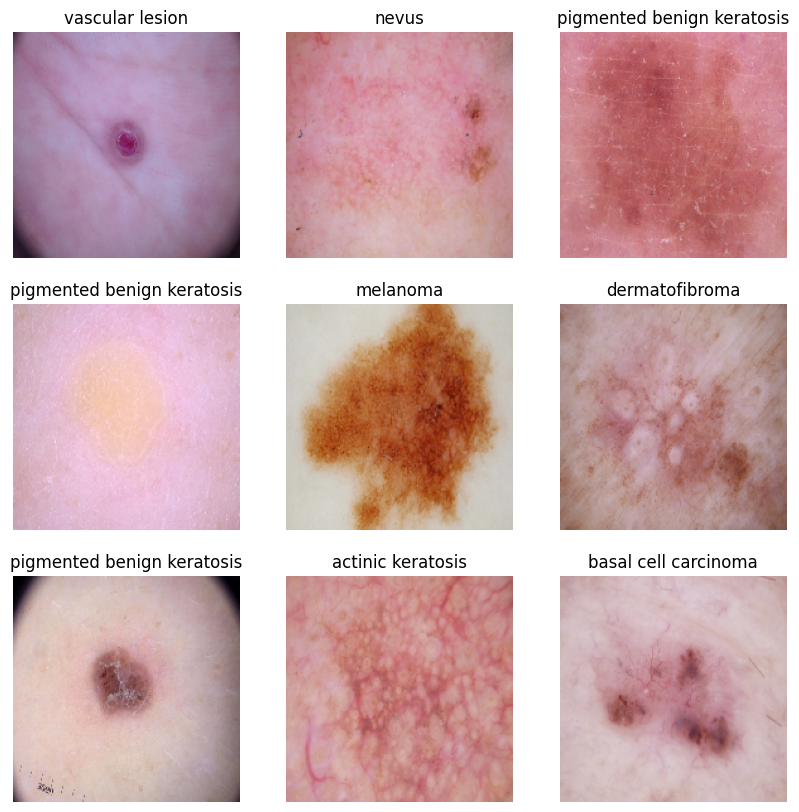

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [ ]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 86, 86, 64)        256       
 Normalization)                                         

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 88, 88, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 86, 86, 64)        256       
 Normalization)                                         

### Train the model

In [ ]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 820s 8s/step - loss: -78644.0078 - accuracy: 0.1696 - val_loss: -78247.3594 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 301s 5s/step - loss: -793281.3750 - accuracy: 0.1724 - val_loss: -785427.1250 - val_accuracy: 0.1499
Epoch 3/20
56/56 [==============================] - 299s 5s/step - loss: -2948177.2500 - accuracy: 0.1724 - val_loss: -2522195.5000 - val_accuracy: 0.1499
Epoch 4/20
56/56 [==============================] - 295s 5s/step - loss: -7284659.0000 - accuracy: 0.1724 - val_loss: -7116359.5000 - val_accuracy: 0.1499
Epoch 5/20
56/56 [==============================] - 298s 5s/step - loss: -14590299.0000 - accuracy: 0.1724 - val_loss: -10967266.0000 - val_accuracy: 0.1499
Epoch 6/20
56/56 [==============================] - 304s 5s/step - loss: -25497506.0000 - accuracy: 0.1724 - val_loss: -27121224.0000 - val_accuracy: 0.1499
Epoch 7/20
56/56 [==============================] - 298s 5s/step - loss:

### Visualizing training results

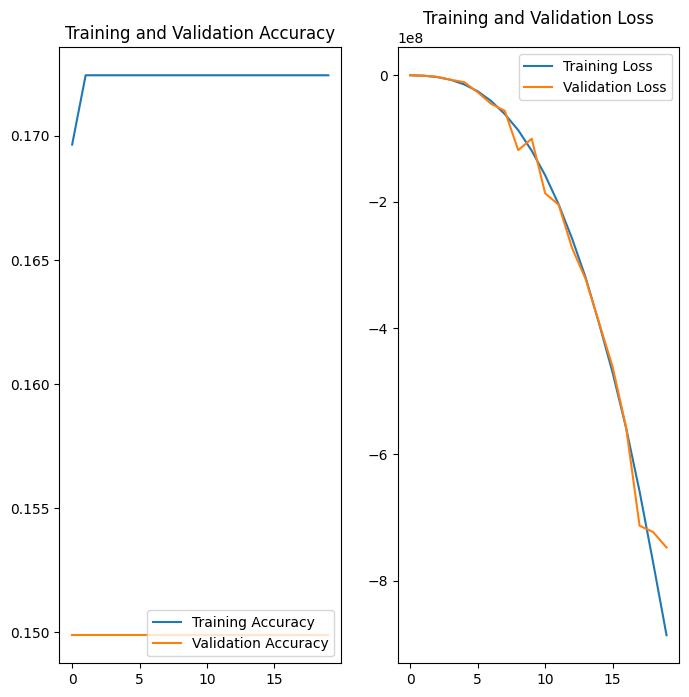

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model Overfit or Underfit?

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 18s 1s/step - loss: -747622272.0000 - accuracy: 0.1499
Accuracy:  0.1724330335855484
Validation Accuracy:  0.14988814294338226
Loss:  -729461120.0
Validation Loss -747622272.0


In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


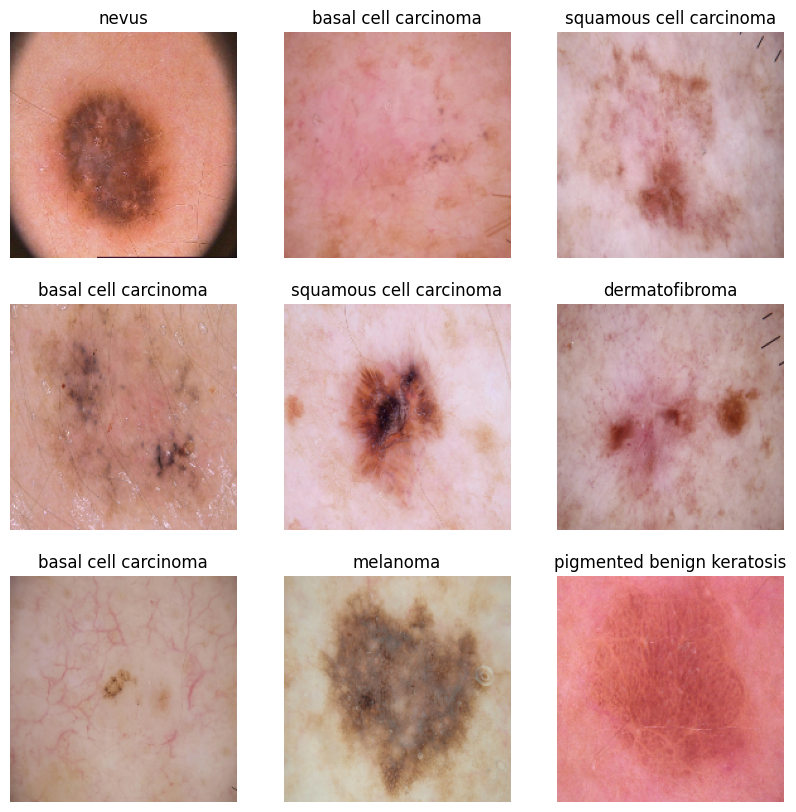

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Create the model, compile and train the model

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 64)        36928     
                                                      

Compiling the mode

In [ ]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001)

Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 258s 18s/step - loss: 20.9052 - accuracy: 0.3966 - val_loss: 0.3328 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 219s 15s/step - loss: 0.2426 - accuracy: 0.4876 - val_loss: 0.4501 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 228s 16s/step - loss: 0.2106 - accuracy: 0.5124 - val_loss: 0.5302 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.6090 
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 220s 15s/step - loss: 0.1817 - accuracy: 0.6090 - val_loss: 0.4679 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 206s 14s/step - loss: 0.1742 - accuracy: 0.6258 - val_loss: 0.4180 - val_accuracy: 0.3542 - lr: 5.0000e-04
Epoch 6/20
14/14 [==============================] - 209s 15s

Visualizing the results

<built-in method keys of dict object at 0x7f84d0115a00> :


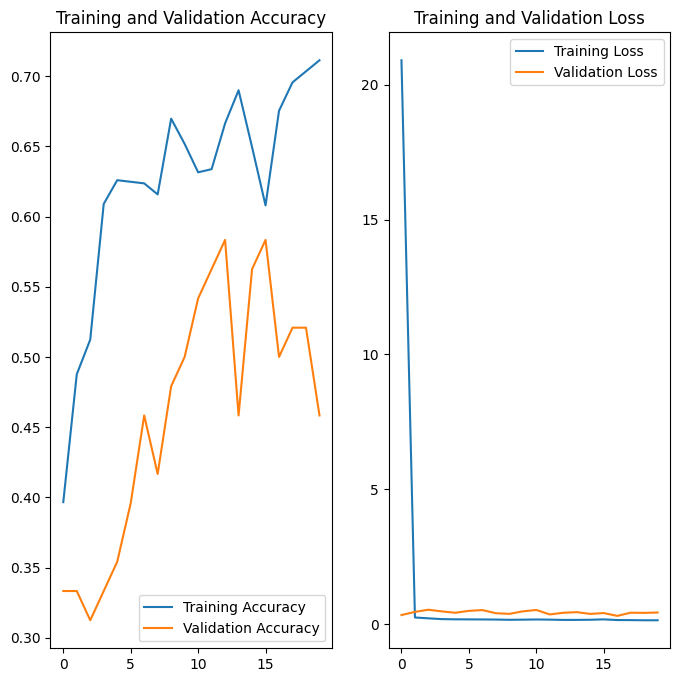

In [ ]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

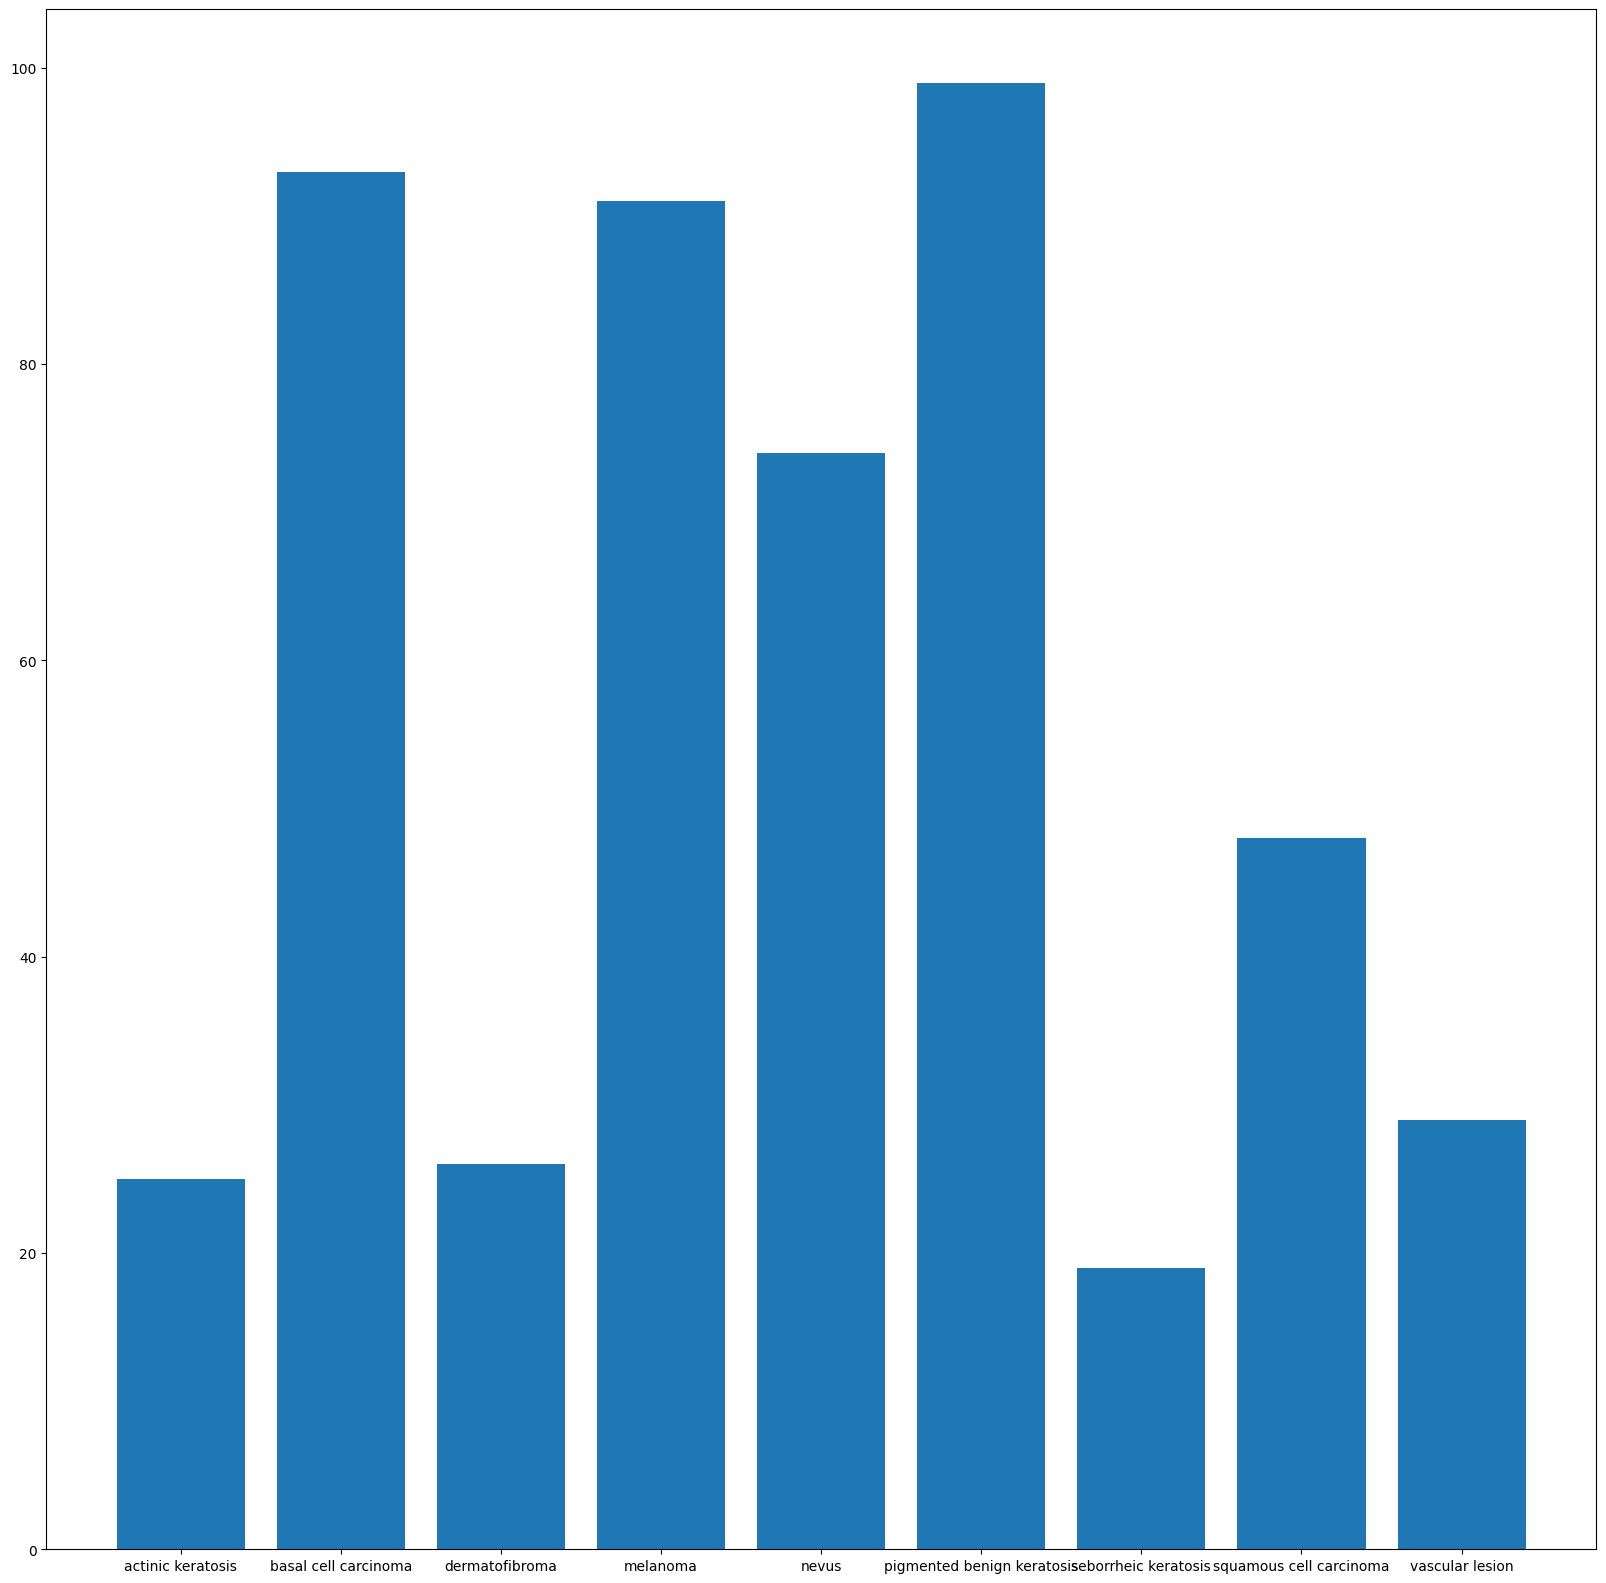

In [ ]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN/Skin cancer/Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F84B3FABB80>: 100%|██████████| 500/500 [00:24<00:00, 20.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84B3FABDF0>: 100%|██████████| 500/500 [00:22<00:00, 22.15 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84C1A73760>: 100%|██████████| 500/500 [00:23<00:00, 21.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F84C1CB7250>: 100%|██████████| 500/500 [01:35<00:00,  5.22 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F84C1CA5990>: 100%|██████████| 500/500 [01:40<00:00,  4.95 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84B4009420>: 100%|██████████| 500/500 [00:24<00:00, 20.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F84C1847A60>: 100%|██████████| 500/500 [00:46<00:00, 10.78 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84B3E43370>: 100%|██████████| 500/500 [00:24<00:00, 20.01 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Skin cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F84C1847790>: 100%|██████████| 500/500 [00:23<00:00, 21.36 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN/Skin cancer/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011125.jpg_39d9f749-519f-4b06-80af-2488a99f7995.jpg',
 '/content/gdrive/MyDrive/CNN/Skin cancer/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011126.jpg_09ee3a3f-e1d7-4b27-8cbe-810117635013.jpg',
 '/content/gdrive/MyDrive/CNN/Skin cancer/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010995.jpg_6be5a5bf-3431-4e59-9bb8-fe730ed75768.jpg',
 '/content/gdrive/MyDrive/CNN/Skin cancer/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011077.jpg_1c7dd85b-afcb-4c6d-829b-c4afdfd44fe6.jpg',
 '/content/gdrive/MyDrive/CNN/Skin cancer/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011043.jpg_30436abe-eff3-41ad-8306-e9c59b4fbf4d.jpg',
 '/content/gdrive/MyDrive/CNN/Skin cancer/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011040.jpg_0260e47f-6a8b-4641-9678-55458cfa15b1.jpg',
 '/c

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',
 'seborrheic keratosis',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

seborrheic keratosis          500
pigmented benign keratosis    500
vascular lesion               500
basal cell carcinoma          500
dermatofibroma                500
actinic keratosis             500
squamous cell carcinoma       500
melanoma                      500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/CNN/Skin cancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 90, 90, 32)        128       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 64)       

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
### Todo, choose an appropirate optimiser and loss function

optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [ ]:

epochs = 20

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,  # Adjust verbosity level
                                            factor=0.5,
                                            min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
                    epochs=epochs,
                    verbose=1,
                    validation_data=val_ds,
                    callbacks=[learning_rate_reduction])


Epoch 1/20
169/169 [==============================] - 1282s 8s/step - loss: -21.1448 - accuracy: 0.1337 - val_loss: -2.3342 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/20
169/169 [==============================] - 1213s 7s/step - loss: -88.4156 - accuracy: 0.1337 - val_loss: -167.4455 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 3/20
169/169 [==============================] - 1222s 7s/step - loss: -219.5141 - accuracy: 0.1337 - val_loss: -681.0545 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 4/20
169/169 [==============================] - ETA: 0s - loss: -414.9196 - accuracy: 0.1337
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 1220s 7s/step - loss: -414.9196 - accuracy: 0.1337 - val_loss: -698.2441 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 5/20
169/169 [==============================] - 1253s 7s/step - loss: -607.8950 - accuracy: 0.1337 - val_loss: -949.2117 - val_accuracy: 0.1151 - lr: 5.0000e-04
Epoch 6/20
169/169 [=

#### **Todo:**  Visualize the model results

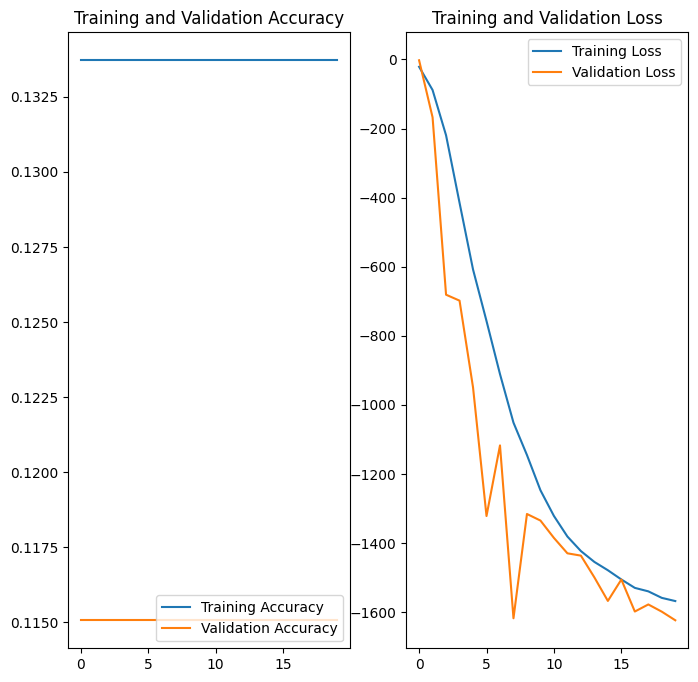

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()